##Работа в [XGboost](https://arxiv.org/abs/1603.02754)

Загружаем библиотеки:

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris,load_digits, load_boston
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## **Параметры XGBoost**

Выделяют три группы параметров:
- Общие параметры, отвечающие за базовый алгоритм для бустинга и распараллеливание.
- Параметры выбранного базового алгоритма.
- Параметры обучения, отвечающие за функцию потерь и метрику качества на валидации.

**1. Общие параметры:**
- booster [default=gbtree] - тип базового алгоритма для бустинга: дерево решений gbtree или линейная модель gblinear. 
- silent [default=0] - выдавать (silent=0) или нет (silent=1) сообщения по ходу работы алгоритма.
- nthread [default to maximum number of threads available if not set] - число нитей доступных для параллельной работы xgboost.

**2. Параметры базового алгоритма:**

**2.1. Дерево решений:**
- eta [default=0.3] - темп обучения, перед добавлением дерева в композицию оно умножается на eta. Используется для предотвращения переобучения за счёт "сокращения" весов базовых алгоритмов, делая модель более консервативной. Чем меньше eta, тем больше нужно итераций num_boost_round для обучения модели с хорошим качеством. Диапазон: [0, 1]
- gamma [default=0] - минимальное снижение значения функции потерь, необходимое для дальнейшего разбиения вершины дерева. Большие значения gamma > 0 приводят к более консервативным моделям. Диапазон: [0, $\infty$).
- max_depth [default=6] - максимальная глубина дерева. Диапазон: [1, $\infty$). 
- min_child_weight [default=1] - минимальное необходимое (взвешенное) число примеров в каждой вершине. Чем больше, тем более консервативна итоговая модель. Диапазон: [0, $\infty$).
- max_delta_step [default=0] - обычно равен нулю. Положительные значения используются при несбалансированных классах для ускорения сходимости. Диапазон [0, $\infty$).
- subsample [default=1] - доля выборки, используемая для обучения каждого дерева. Если subsample < 1, то выбирается случайная подвыборка, что помогает в борьбе с переобучением. Диапазон: (0, 1]
- colsample_bytree [default=1] - доля признаков, используемая для обучения каждого дерева. Диапазон: (0, 1]
- lambda [default=1] - коэффициент перед $L_2$-регуляризатором в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором в функции потерь.

**2.2. Линейная модель:**
- lambda [default=0] - коэффициент перед $L_2$-регуляризатором вектора весов в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором вектора весов в функции потерь.
- lambda_bias [default=0] - коэффициент перед $L_2$-регуляризатором смещения (свободного члена) в функции потерь.

**3. Параметры задачи обучения:**
- objective [default=reg:linear] - используемая при обучении функция потерь:
    - "reg:linear" – линейная регрессия.
    - "reg:logistic" – логистическая регрессия.
    - "binary:logistic" – логистическая регрессия для бинарной классификации, на выходе - вероятность.
    - "binary:logitraw" – то же самое, но на выходе - значение до его преобразования логистической функцией.
    - "count:poisson" – регрессия Пуассона (используется для оценки числа каких-то событий, счётный признак), на выходе - матожидания распределения Пуассона. В этом случае max_delta_step автоматически устанавливается равным 0.7.
    - "multi:softmax" – обобщение логистической регрессии на многоклассовый случай. При этом нужно задать параметр num_class.
    - "multi:softprob" – то же самое, но на выходе - вектор размера ndata * nclass, который можно преобразовать в матрицу, содержащую вероятности отнесения данного объекта к данному классу.
    - "rank:pairwise" – используется для задач ранжирования.
- base_score [default=0.5] - инициализация значения модели для всех примеров, глобальное смещение.
- eval_metric [default according to objective] - метрика качества на валидационной выборке (по умолчанию соответствует функции потерь: rmse - для регрессии, error - для классификации, mean average precision - для ранжирования). Выбрать можно одну из следующих метрик:
    - "rmse": root mean square error.
    - "logloss": минус логарифм правдоподобия.
    - "error": доля ошибок для бинарной классификации.
    - "merror": то же самое для многоклассовой классификации.
    - "mlogloss": logloss для многоклассовой классификации.
    - "auc": AUC.
    - "ndcg": Normalized Discounted Cumulative Gain.
    - "map": Mean average precision.
    - "ndcg@n",”map@n”: здесь n - целое число, первые n позиций в списке не учитываются.
    - "ndcg-",”map-”,”ndcg@n-”,”map@n-”: списку из всех положительных примеров будет присвоено значение 0 (вместо 1).
- seed [default=0] - для воспроизводимости "случайности".

**Параметры в xgboost.train**:
- params (dict) – параметры, описанные выше.
- dtrain (DMatrix) – обучающая выборка.
- num_boost_round (int) – число итераций бустинга.
- evals (list) – список для оценки качества во время обучения.
- obj (function) – собственная функция потерь.
- feval (function) – собственная функция для оценки качества.
- maximize (bool) – нужно ли максимизировать feval.
- early_stopping_rounds (int) – активирует early stopping. Ошибка на валидации должна уменьшаться каждые early_stopping_rounds итераций для продолжения обучения. Список evals должен быть не пуст. Возвращается модель с последней итерации. Если произошел ранний останов, то модель будет содержать поля: bst.best_score и bst.best_iteration.
- evals_result (dict) – результаты оценки качества.
- verbose_eval (bool) – вывод значения метрики качества на каждой итерации бустинга.
- learning_rates (list or function) – коэффициент скорости обучения для каждой итерации - list l: eta = l[boosting round] - function f: eta = f(boosting round, num_boost_round).
- xgb_model (file name of stored xgb model or ‘Booster’ instance) – возможность продолжить обучения имеющейся модели XGB.

Пример использования Xgboost для классификации на данных Iris.



In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=20)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 8  0  0]
 [ 0 11  0]
 [ 0  3  8]]
[[12  0  0]
 [ 0 11  0]
 [ 0  1  6]]
[[ 7  0  0]
 [ 0 13  0]
 [ 0  1  9]]
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
[[13  0  0]
 [ 0  4  2]
 [ 0  0 11]]


Пример восстановления регрессии с Xgboost на данных boston.

In [4]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror').fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

9.047410732647124
8.691280669876079
15.025941773762074
7.385308075054494
7.329729069724167


Простой пример подбора параметров с GridSearchCV.

In [5]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_grid = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6,8]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.5899096962627829
{'max_depth': 4}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась, используется ранняя остановка:

In [6]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.14000
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.10667
[2]	validation_0-merror:0.08222
[3]	validation_0-merror:0.08000
[4]	validation_0-merror:0.06667
[5]	validation_0-merror:0.06444
[6]	validation_0-merror:0.07111
[7]	validation_0-merror:0.07111
[8]	validation_0-merror:0.06889
[9]	validation_0-merror:0.06667
[10]	validation_0-merror:0.06444
[11]	validation_0-merror:0.06667
[12]	validation_0-merror:0.06889
[13]	validation_0-merror:0.06000
[14]	validation_0-merror:0.05778
[15]	validation_0-merror:0.06222
[16]	validation_0-merror:0.06000
[17]	validation_0-merror:0.05778
[18]	validation_0-merror:0.05556
[19]	validation_0-merror:0.05333
[20]	validation_0-merror:0.05556
[21]	validation_0-merror:0.05556
[22]	validation_0-merror:0.04889
[23]	validation_0-merror:0.04889
[24]	validation_0-merror:0.05111
[25]	validation_0-merror:0.05333
[26]	validation_0-merror:0.05111
[27]	validation_0-merror:0.04889
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=None, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

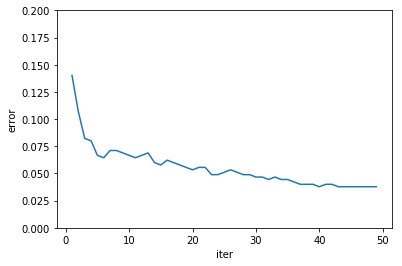

In [7]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel('iter');
plt.ylabel('error');
plt.ylim(0, 0.2);

## Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.

> **Важно**: XGBoost поддерживает только числовые признаки. Поэтому текстовые признаки требуют предобработки

Для обучения с Xgboost данные должны быть представлены в виде объекта `DMatrix`, предназначенного для представления разреженных данных. Его можно инициализировать через:
- текстовый формат libsvm,
-  Numpy 2D array (чаще всего)
- бинарный буфер-файл XGBoost 

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving telecom_churn.csv to telecom_churn.csv
User uploaded file "telecom_churn.csv" with length 279997 bytes


In [8]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Предобработка:**

штаты просто занумеруем (хотя можно и лучше поступить), а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [9]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [11]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 2333 rows and 19 columns
Test dataset contains 1000 rows and 19 columns


### Инициализация параметров

- бинарная классификация (`'objective':'binary:logistic'`)
- ограничим глубину деревьев (`'max_depth':3`)
- не хотим лишнего вывода (`'silent':1`)
- проведем 50 итераций бустинга
- шаг градиентного спуска довольно большой (`'eta':1`) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)

In [12]:
params = {
    'objective':'binary:logistic',
    'max_depth': 3,
    'silent': 1,
    'eta': 1
}

num_rounds = 50

Обучим градиентный бустинг с заданными параметрами. Обратите вни мание, мы это делаем через c помощью xgboost.train()!!!

In [13]:
xgb_model = xgb.train(params, dtrain, num_rounds)

Если передать на вход словарь соответствующих данных, можно проследить за качеством обучения на отдельной итерации.

In [14]:
 evals= [(dtrain,'train'),(dtest,'test')] # для оценки качества во время обучения 
xgb_model =xgb.train(params, dtrain, num_rounds,evals)

[0]	train-error:0.09087	test-error:0.11600
[1]	train-error:0.06858	test-error:0.10200
[2]	train-error:0.04029	test-error:0.07100
[3]	train-error:0.03472	test-error:0.06400
[4]	train-error:0.03601	test-error:0.07100
[5]	train-error:0.03386	test-error:0.07000
[6]	train-error:0.03215	test-error:0.06900
[7]	train-error:0.03043	test-error:0.07300
[8]	train-error:0.02872	test-error:0.07000
[9]	train-error:0.02872	test-error:0.07400
[10]	train-error:0.02829	test-error:0.07000
[11]	train-error:0.02872	test-error:0.07000
[12]	train-error:0.02658	test-error:0.06300
[13]	train-error:0.02443	test-error:0.06700
[14]	train-error:0.02186	test-error:0.06900
[15]	train-error:0.02143	test-error:0.06900
[16]	train-error:0.02186	test-error:0.06800
[17]	train-error:0.01929	test-error:0.06300
[18]	train-error:0.02100	test-error:0.07000
[19]	train-error:0.01886	test-error:0.06700
[20]	train-error:0.01929	test-error:0.06900
[21]	train-error:0.01800	test-error:0.06800
[22]	train-error:0.01672	test-error:0.0650

Или записать результаты в словарь, в данном примере в пустой словарь results.

In [15]:
params['eval_metric'] = ['logloss', 'auc']
results={}
xgb_model = xgb.train(params, dtrain, num_rounds, evals,evals_result=results)

[0]	train-logloss:0.29641	train-auc:0.85076	test-logloss:0.33282	test-auc:0.78500
[1]	train-logloss:0.21573	train-auc:0.90968	test-logloss:0.27720	test-auc:0.84752
[2]	train-logloss:0.16440	train-auc:0.92627	test-logloss:0.23202	test-auc:0.86381
[3]	train-logloss:0.14914	train-auc:0.93375	test-logloss:0.22528	test-auc:0.87709
[4]	train-logloss:0.14201	train-auc:0.95079	test-logloss:0.22919	test-auc:0.87211
[5]	train-logloss:0.13463	train-auc:0.95424	test-logloss:0.22992	test-auc:0.87699
[6]	train-logloss:0.13057	train-auc:0.95743	test-logloss:0.23115	test-auc:0.87596
[7]	train-logloss:0.12561	train-auc:0.96266	test-logloss:0.22990	test-auc:0.88139
[8]	train-logloss:0.12286	train-auc:0.96505	test-logloss:0.22937	test-auc:0.88306
[9]	train-logloss:0.11519	train-auc:0.97367	test-logloss:0.23540	test-auc:0.88628
[10]	train-logloss:0.10849	train-auc:0.97866	test-logloss:0.22859	test-auc:0.88675
[11]	train-logloss:0.10451	train-auc:0.98278	test-logloss:0.22711	test-auc:0.89049
[12]	train-log

Соответсвующие графики:

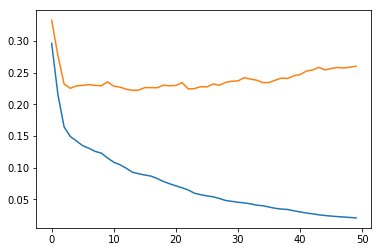

In [16]:
plt.plot(results['train']['logloss'])
plt.plot(results['test']['logloss'])

In [17]:
preds_prob = xgb_model.predict(dtest) #прогнозы для тестовой выборки

In [18]:
predicted_labels = preds_prob > 0.5
print("Accuracy and F1 on the test set are: {} and {}".format(
    round(accuracy_score(y_test, predicted_labels), 3),
    round(f1_score(y_test, predicted_labels), 3)))

Accuracy and F1 on the test set are: 0.935 and 0.749


**Важность признаков**

F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.

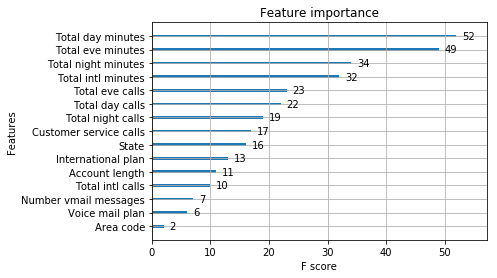

In [19]:
xgb.plot_importance(xgb_model);

In [20]:
importances = xgb_model.get_fscore()
importances

{'Customer service calls': 17,
 'Total day minutes': 52,
 'International plan': 13,
 'Voice mail plan': 6,
 'Total eve minutes': 49,
 'Number vmail messages': 7,
 'Total intl minutes': 32,
 'Total intl calls': 10,
 'Total night minutes': 34,
 'State': 16,
 'Total day calls': 22,
 'Account length': 11,
 'Total night calls': 19,
 'Total eve calls': 23,
 'Area code': 2}

## **Борьба с недообучением и переобучением**

Построим кривые вадидации Xgboost по числу деревьев в задаче классификации синтетических данных.

In [27]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from scipy.sparse import vstack
from xgboost.sklearn import XGBClassifier

In [28]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #Будем проводить 10-кратную стратифицированную кросс-валидацию. 

In [29]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': True
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

KeyboardInterrupt: 

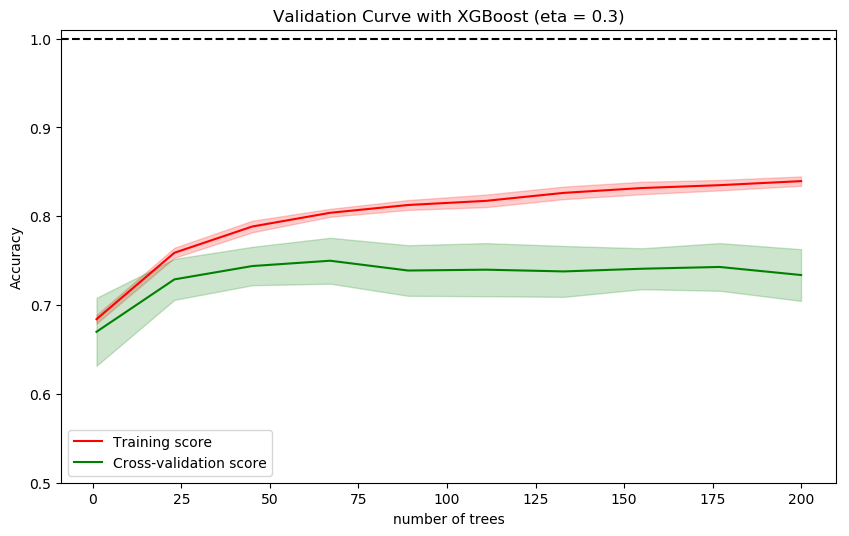

Best cross-validation result (0.75) obtained for 67 trees


In [24]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

**Что заметно:**

- Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
- Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
- Начиная с 25 деревьев, разброс ошибки начинает расти
- Модель довольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.

Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

### Что можно улучшить?

#### Снижение разброса
Для уменьшения сложности модели можно:
- использовать меньше признаков (например, отбор)
- использовать больше объектов (например, искусственно созданных)
- увеличить регуляризацию

В случае XGBoost можно:
- уменьшать максимальную глубину деревьев(`max_depth`)
- увеличивать значение параметра `min_child_weight`
- увеличивать значение параметра `gamma`
- добавлять больше "случайности" за счет параметров `subsample` и `colsample_bytree`
- увеличивать значение паарметров регуляризации `lambda` и `alpha`

#### Снижение смещения
Если модель слишком простая, можно:
- добавлять больше признаков (например, изобретать их),
- усложнять модель
- уменьшать регуляризацию

В случае XGBoost можно:
- увеличивать максимальную глубину деревьев(`max_depth`)
- уменьшать значение параметра `min_child_weight`
- уменьшать значение параметра `gamma`
- уменьшать значение параметров регуляризации `lambda` и `alpha`

**Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.**

In [25]:
new_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'silent': True,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7, # added
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(**new_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

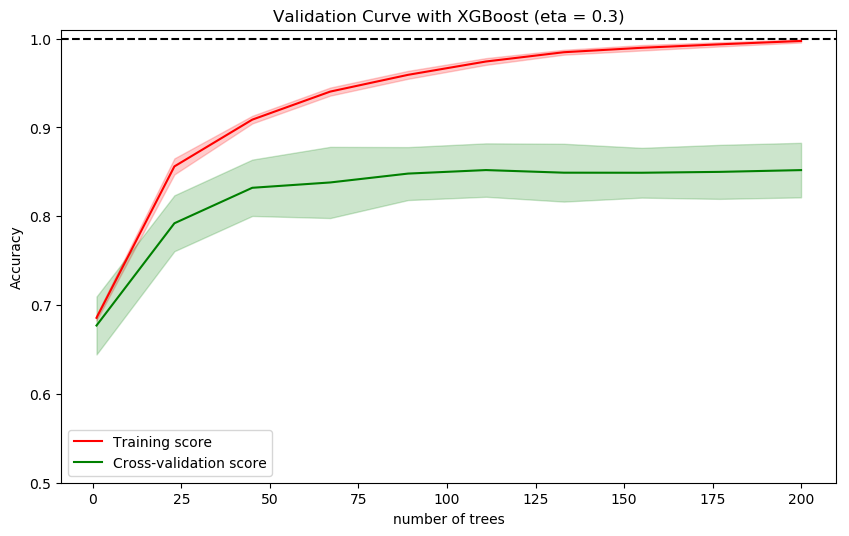

Best cross-validation result (0.85) obtained for 111 trees


In [26]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))